In [31]:
import pandas as pd
import numpy as np


def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

df = get_data([170624, 170701, 170708, 170715, 170722, 170729])
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1184633 entries, 0 to 200111
Data columns (total 11 columns):
 #   Column                                                                Non-Null Count    Dtype 
---  ------                                                                --------------    ----- 
 0   C/A                                                                   1184633 non-null  object
 1   UNIT                                                                  1184633 non-null  object
 2   SCP                                                                   1184633 non-null  object
 3   STATION                                                               1184633 non-null  object
 4   LINENAME                                                              1184633 non-null  object
 5   DIVISION                                                              1184633 non-null  object
 6   DATE                                                                  1184633 non-n

In [2]:
df.rename(columns=lambda x: x.strip(), inplace= True)

## framing questions 
-  When to shut down for maintenance?
-  Which tracks need repairing ?
-  In which order should the MTA schedule their track maintenance?
-  What are the alternate lines available in the station?


## cleaning
rename cols, remove blanks, look for nulls

In [3]:
import matplotlib.pyplot as plt


63 days

In [4]:
df.DATE.value_counts().sort_index()

06/17/2017    27980
06/18/2017    28093
06/19/2017    28513
06/20/2017    28107
06/21/2017    28075
06/22/2017    28410
06/23/2017    28238
06/24/2017    28045
06/25/2017    28107
06/26/2017    28084
06/27/2017    28096
06/28/2017    28533
06/29/2017    28372
06/30/2017    28184
07/01/2017    28129
07/02/2017    28125
07/03/2017    28360
07/04/2017    28033
07/05/2017    27484
07/06/2017    27223
07/07/2017    28212
07/08/2017    27962
07/09/2017    28009
07/10/2017    28216
07/11/2017    28226
07/12/2017    28050
07/13/2017    28172
07/14/2017    28049
07/15/2017    28095
07/16/2017    28019
07/17/2017    28109
07/18/2017    28304
07/19/2017    28412
07/20/2017    28064
07/21/2017    28431
07/22/2017    28045
07/23/2017    28098
07/24/2017    28415
07/25/2017    28413
07/26/2017    29843
07/27/2017    28065
07/28/2017    29233
Name: DATE, dtype: int64

In [5]:
import datetime
df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [30]:
df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [7]:
ts_daily = (df
            .groupby(["C/A", "UNIT", "SCP", "STATION", "LINENAME" ,"DATE_TIME"],as_index=False)
            .ENTRIES.first())




In [8]:
ts_daily[["PREV_DATE", "PREV_ENTRIES"]] = (ts_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION","LINENAME"])["DATE_TIME","ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

ts_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

<ipython-input-8-ab6322c01a46>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ts_daily[["PREV_DATE", "PREV_ENTRIES"]] = (ts_daily


In [9]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
ts_daily["DAILY_ENTRIES"] = ts_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

5439480 7807254.0
1079 1340598.0
77 1036866.0
24 2355469.0
0 4017898.0
4017898 0.0
1567690923 1624939.0
1627413160 6389847.0
67 6737078.0
1795 17546467.0
1051 2156003.0
7 8266480.0
206 16594634.0
150995082 892648.0
1173 5244254.0
114 1852696.0
6 134254774.0
11 20518689.0
79 1539105.0
10 2163204.0
39 10610211.0
150994944 1090866487.0
134217738 25673.0
83886131 76991.0
4084118 102746811.0
100964269 4083712.0
4314484 100964214.0
409 4314407.0
1073550180 100848690.0
458825 67241076.0
16777239 459687.0
117440578 16777527.0
132 2446091.0
28 1684866.0
117528648 67168456.0
22 3614530.0
55 5449984.0
330 12099316.0
146 2520625.0
1073708202 8607258.0
8607302 1073708202.0
1610613814 276184.0
276195 1610613814.0
274 29162655.0
46 10475840.0
855676885 3394086.0
66704 3609439.0
201327155 1204118.0
589854 2695717.0
0 67108864.0
64 1113795.0
2018 5432922.0
1572880 571098.0


In [10]:
#ts_daily.set_index(["DATE_TIME"],inplace= True)


## Top Stations

In [11]:
stations = ts_daily.groupby("STATION").DAILY_ENTRIES.sum()
stations.sort_values()

STATION
BROAD CHANNEL        10854.0
ORCHARD BEACH        13301.0
BEACH 105 ST         20026.0
AVENUE I             24255.0
BEACH 44 ST          26108.0
                     ...    
14 ST-UNION SQ     4659935.0
23 ST              4889667.0
34 ST-HERALD SQ    5159592.0
GRD CNTRL-42 ST    5188431.0
34 ST-PENN STA     5664514.0
Name: DAILY_ENTRIES, Length: 376, dtype: float64

In [39]:
lines = ts_daily.groupby("LINENAME").DAILY_ENTRIES.sum()
lines.sort_values(ascending= False)

LINENAME
1        31693148.0
6        12377332.0
7         9191888.0
25        6744350.0
F         6604484.0
            ...    
7EFMR      124791.0
23ACE      105338.0
R2345       89875.0
S           65006.0
S2345       47516.0
Name: DAILY_ENTRIES, Length: 114, dtype: float64

pick one line and get the traffic on in 

In [13]:
line_one = ts_daily[(ts_daily.LINENAME.str.contains('1')) & (ts_daily.STATION == '34 ST-PENN STA')]
line_one.drop(columns=['PREV_DATE', 'PREV_ENTRIES'],inplace= True)

/Users/jennansowayan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [48]:
line = line_one[(line_one.DATE_TIME >= '2017-07-27 00:00:00') & (line_one.DATE_TIME < '2017-07-29 00:00:00')]

In [23]:
n = line.groupby(["DATE_TIME"]).DAILY_ENTRIES.sum()

/Users/jennansowayan/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Summer Of Hell Effect on Line Entries'}, xlabel='Time Stamp', ylabel='individual Entries'>

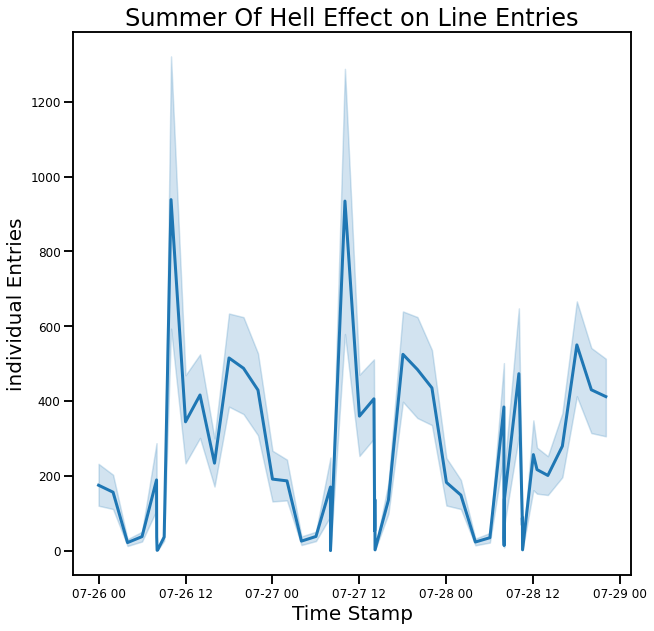

In [49]:
import seaborn as sns
sns.set_context("talk")
plt.style.use('presentation.mplstyle')
plt.xlabel('Time Stamp')
plt.ylabel('individual Entries')
plt.title("Summer Of Hell Effect on Line Entries")
sns.lineplot(line.DATE_TIME, line.DAILY_ENTRIES)
